In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data
meta_groups = pd.read_csv("meta-groups.csv")
meta_events = pd.read_csv("meta-events.csv")
rsvps = pd.read_csv("rsvps.csv")

In [3]:
# Merge meta_events with rsvps to get total_participants
event_participants = rsvps.groupby('event_id').size().reset_index(name='total_participants')

In [4]:
event_participants

event_id  total_participants
0         107248742                   2
1         117878862                  61
2         133313452                  23
3         145868842                   5
4         160315242                  68
...             ...                 ...
19026  zxlwkmywjblb                  31
19027  zxnlxlyvnbbc                   6
19028  zxnlxlyvnbjb                   7
19029  zxnlxlyvnbkc                   6
19030  zxnlxlyvnbrb                   7

[19031 rows x 2 columns]

In [5]:
# Merge with meta_events to get group category and time
event_data = meta_events.merge(meta_groups[['group_id', 'category_name']], on='group_id')
event_data = event_data.merge(event_participants, on='event_id')

In [6]:
event_data

event_id  group_id  \
0         243930425  26140018   
1         244208851  25604533   
2      pxlktnywnbfb  25973656   
3         244444551  18571126   
4         244257722  18571126   
...             ...       ...   
19026     240776561    339011   
19027     240315974    339011   
19028  qvbrfnywjbtb    339011   
19029     240754899    339011   
19030     240315962    339011   

                                                    name                 time  \
0      2017 Nashville Walk to End Alzheimers - Octob...  2017-10-14 12:00:00   
1                              Steak Dinner on the Patio  2017-10-15 00:15:00   
2                                        Schedule Meetup  2017-10-03 23:30:00   
3      Happy Hour Wednesday, Jonathan's Green Hills, ...  2017-10-25 22:30:00   
4               Happy Hour Wednesday, Brentwood, Oct. 18  2017-10-18 22:30:00   
...                                                  ...                  ...   
19026  Beaman Park - 6.6 Mile Moderate Hike in northw...  2017-06-17 13:00:00   
19027  River Walk to Crockett Park - moderate weekday...  2017-06-16 14:00:00   
19028                      Edwin Warner Park Sunset Hike  2017-06-15 23:00:00   
19029  LAST MINUTE!!! 2.5 Mile Night Hike @ Edwin War...  2017-06-14 23:30:00   
19030  River Walk to Crockett Park - moderate weekday...  2017-06-14 14:00:00   

                 category_name  total_participants  
0      Community & Environment                   1  
1               Pets & Animals                   1  
2                      Support                   2  
3            Career & Business                   1  
4            Career & Business                   1  
...                        ...                 ...  
19026     Outdoors & Adventure                  13  
19027     Outdoors & Adventure                   4  
19028     Outdoors & Adventure                  18  
19029     Outdoors & Adventure                   5  
19030     Outdoors & Adventure                   3  

[19031 rows x 6 columns]

In [7]:
# Extract month, day of the week, and time of the day
event_data['time'] = pd.to_datetime(event_data['time'])
event_data['month'] = event_data['time'].dt.month_name()
event_data['day_of_the_week'] = event_data['time'].dt.day_name()
event_data['hour'] = event_data['time'].dt.hour
event_data['time_of_the_day'] = pd.cut(event_data['hour'], bins=[0, 6, 12, 18, 24], labels=['night', 'morning', 'afternoon', 'evening'], right=False)

In [8]:
event_data

event_id  group_id  \
0         243930425  26140018   
1         244208851  25604533   
2      pxlktnywnbfb  25973656   
3         244444551  18571126   
4         244257722  18571126   
...             ...       ...   
19026     240776561    339011   
19027     240315974    339011   
19028  qvbrfnywjbtb    339011   
19029     240754899    339011   
19030     240315962    339011   

                                                    name                time  \
0      2017 Nashville Walk to End Alzheimers - Octob... 2017-10-14 12:00:00   
1                              Steak Dinner on the Patio 2017-10-15 00:15:00   
2                                        Schedule Meetup 2017-10-03 23:30:00   
3      Happy Hour Wednesday, Jonathan's Green Hills, ... 2017-10-25 22:30:00   
4               Happy Hour Wednesday, Brentwood, Oct. 18 2017-10-18 22:30:00   
...                                                  ...                 ...   
19026  Beaman Park - 6.6 Mile Moderate Hike in northw... 2017-06-17 13:00:00   
19027  River Walk to Crockett Park - moderate weekday... 2017-06-16 14:00:00   
19028                      Edwin Warner Park Sunset Hike 2017-06-15 23:00:00   
19029  LAST MINUTE!!! 2.5 Mile Night Hike @ Edwin War... 2017-06-14 23:30:00   
19030  River Walk to Crockett Park - moderate weekday... 2017-06-14 14:00:00   

                 category_name  total_participants    month day_of_the_week  \
0      Community & Environment                   1  October        Saturday   
1               Pets & Animals                   1  October          Sunday   
2                      Support                   2  October         Tuesday   
3            Career & Business                   1  October       Wednesday   
4            Career & Business                   1  October       Wednesday   
...                        ...                 ...      ...             ...   
19026     Outdoors & Adventure                  13     June        Saturday   
19027     Outdoors & Adventure                   4     June          Friday   
19028     Outdoors & Adventure                  18     June        Thursday   
19029     Outdoors & Adventure                   5     June       Wednesday   
19030     Outdoors & Adventure                   3     June       Wednesday   

       hour time_of_the_day  
0        12       afternoon  
1         0           night  
2        23         evening  
3        22         evening  
4        22         evening  
...     ...             ...  
19026    13       afternoon  
19027    14       afternoon  
19028    23         evening  
19029    23         evening  
19030    14       afternoon  

[19031 rows x 10 columns]

In [9]:
# Drop unnecessary columns
event_data.drop(columns=['event_id', 'time', 'hour', 'name'], inplace=True)

In [10]:
# One-hot encode categorical variables
event_data = pd.get_dummies(event_data, columns=['category_name', 'month', 'day_of_the_week', 'time_of_the_day'])

In [11]:
# Drop unnecessary columns
event_data.drop(columns=['group_id'], inplace=True)

In [12]:
event_data

total_participants  category_name_Arts & Culture  \
0                       1                             0   
1                       1                             0   
2                       2                             0   
3                       1                             0   
4                       1                             0   
...                   ...                           ...   
19026                  13                             0   
19027                   4                             0   
19028                  18                             0   
19029                   5                             0   
19030                   3                             0   

       category_name_Book Clubs  category_name_Career & Business  \
0                             0                                0   
1                             0                                0   
2                             0                                0   
3                             0                                1   
4                             0                                1   
...                         ...                              ...   
19026                         0                                0   
19027                         0                                0   
19028                         0                                0   
19029                         0                                0   
19030                         0                                0   

       category_name_Cars & Motorcycles  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
...                                 ...   
19026                                 0   
19027                                 0   
19028                                 0   
19029                                 0   
19030                                 0   

       category_name_Community & Environment  category_name_Dancing  \
0                                          1                      0   
1                                          0                      0   
2                                          0                      0   
3                                          0                      0   
4                                          0                      0   
...                                      ...                    ...   
19026                                      0                      0   
19027                                      0                      0   
19028                                      0                      0   
19029                                      0                      0   
19030                                      0                      0   

       category_name_Education & Learning  category_name_Fashion & Beauty  \
0                                       0                               0   
1                                       0                               0   
2                                       0                               0   
3                                       0                               0   
4                                       0                               0   
...                                   ...                             ...   
19026                                   0                               0   
19027                                   0                               0   
19028                                   0                               0   
19029                                   0                               0   
19030                                   0                               0   

       category_name_Fitness  ...  day_of_the_week_Monday  \
0                          0  ...                       0   
1                          0  ...                       0   
2  

In [13]:
# Separate X and y
X = event_data.drop(columns=['total_participants'])
y = event_data['total_participants']

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Build XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 75.25105580135259


In [17]:
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Plot predicted vs. actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Total Participants')
plt.ylabel('Predicted Total Participants')
plt.title('Actual vs. Predicted Total Participants')
plt.show()

In [18]:
from xgboost import plot_importance

# Get feature importance
feature_importance = model.feature_importances_
features = X.columns

# Create dataframe with feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

Feature  Importance
29                        category_name_Tech    0.234068
18      category_name_New Age & Spirituality    0.127636
11          category_name_Health & Wellbeing    0.107253
23          category_name_Religion & Beliefs    0.034072
26                 category_name_Socializing    0.023949
10                       category_name_Games    0.022883
16               category_name_Movies & Film    0.021664
28                     category_name_Support    0.019882
25                     category_name_Singles    0.019256
0               category_name_Arts & Culture    0.019095
47                  day_of_the_week_Thursday    0.017404
21              category_name_Pets & Animals    0.016821
52                 time_of_the_day_afternoon    0.016496
5                      category_name_Dancing    0.016321
44                    day_of_the_week_Monday    0.015549
2            category_name_Career & Business    0.013773
48                   day_of_the_week_Tuesday    0.013447
9                 category_name_Food & Drink    0.013437
53                   time_of_the_day_evening    0.012650
49                 day_of_the_week_Wednesday    0.012067
27         category_name_Sports & Recreation    0.012021
46                    day_of_the_week_Sunday    0.011431
45                  day_of_the_week_Saturday    0.011375
50                     time_of_the_day_night    0.011218
43                    day_of_the_week_Friday    0.010672
19        category_name_Outdoors & Adventure    0.009951
38                               month_March    0.009210
33                            month_December    0.008971
8                      category_name_Fitness    0.008124
15        category_name_Movements & Politics    0.007695
17                       category_name_Music    0.007657
32                              month_August    0.007574
35                             month_January    0.007517
3           category_name_Cars & Motorcycles    0.006986
51                   time_of_the_day_morning    0.006806
24            category_name_Sci-Fi & Fantasy    0.006629
20            category_name_Parents & Family    0.006572
40                            month_November    0.006212
7             category_name_Fashion & Beauty    0.006191
36                                month_July    0.006021
14  category_name_Language & Ethnic Identity    0.005549
37                                month_June    0.005008
31                               month_April    0.004820
41                             month_October    0.004655
6         category_name_Education & Learning    0.004353
12            category_name_Hobbies & Crafts    0.004347
1                   category_name_Book Clubs    0.004167
42                           month_September    0.004122
39                                 month_May    0.003940
34                            month_February    0.003014
30                     category_name_Writing    0.002981
22                 category_name_Photography    0.002425
13                        category_name_LGBT    0.002324
4      category_name_Community & Environment    0.001739

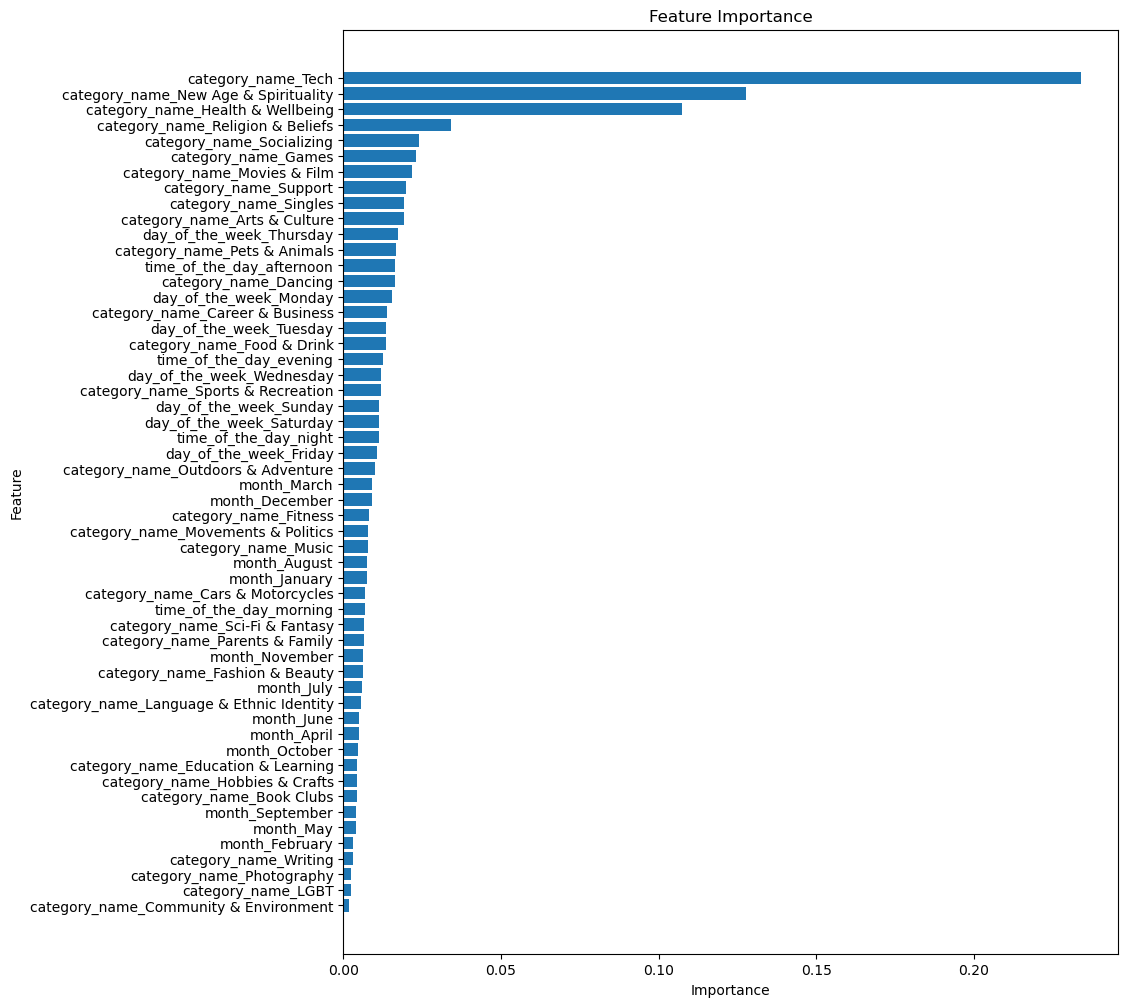

In [19]:
# Sort dataframe by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 12))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [20]:
# Convert y_pred to a DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=['predicted_total_participants'])

# Reset the index of X_test and y_test to match y_pred
X_test_reset_index = X_test.reset_index(drop=True)
y_test_reset_index = y_test.reset_index(drop=True)

# Concatenate X_test, y_test, and y_pred DataFrames horizontally
merged_df = pd.concat([X_test_reset_index, y_test_reset_index, y_pred_df], axis=1)

merged_df.head(10)


category_name_Arts & Culture  category_name_Book Clubs  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   
5                             0                         0   
6                             0                         0   
7                             0                         0   
8                             0                         0   
9                             0                         0   

   category_name_Career & Business  category_name_Cars & Motorcycles  \
0                                1                                 0   
1                                1                                 0   
2                                1                                 0   
3                                0                                 0   
4                                1                                 0   
5                                1                                 0   
6                                1                                 0   
7                                0                                 0   
8                                0                                 0   
9                                0                                 0   

   category_name_Community & Environment  category_name_Dancing  \
0                                      0                      0   
1                                      0                      0   
2                                      0                      0   
3                                      0                      0   
4                                      0                      0   
5                                      0                      0   
6                                      0                      0   
7                                      0                      0   
8                                      0                      0   
9                                      0                      0   

   category_name_Education & Learning  category_name_Fashion & Beauty  \
0                                   0                               0   
1                                   0                               0   
2                                   0                               0   
3                                   0                               0   
4                                   0                               0   
5                                   0                               0   
6                                   0                               0   
7                                   0                               0   
8                                   0                               0   
9                                   0                               0   

   category_name_Fitness  category_name_Food & Drink  ...  \
0                      0                           0  ...   
1                      0                           0  ...   
2                      0                           0  ...   
3                      0                           0  ...   
4                      0                           0  ...   
5                      0                           0  ...   
6                      0                           0  ...   
7                      0                           0  ...   
8                      0                           0  ...   
9                      0                           0  ...   

   day_of_the_week_Sunday  day_of_the_week_Thursday  day_of_the_week_Tuesday  \
0                       0                         1                        0   
1                       0                         0                        0   
2                       0                         0                        0   
3   

For example, if I want to create an event of the category Outdoors & Adventure, in June, on a Saturday morning, the predicted number of participants would be 12.

In [21]:
# Define input features
input_data = {
    'month_June': 0,
    'month_April': 0,
    'month_August': 0,
    'month_December': 0,
    'month_February': 0,
    'month_January': 0,
    'month_July': 1,
    'month_March': 0,
    'month_May': 0,
    'month_November': 0,
    'month_October': 0,
    'month_September': 0,
    'day_of_the_week_Saturday': 0,
    'day_of_the_week_Friday': 0,
    'day_of_the_week_Monday': 0,
    'day_of_the_week_Sunday': 1,
    'day_of_the_week_Thursday': 0,
    'day_of_the_week_Tuesday': 0,
    'day_of_the_week_Wednesday': 0,
    'time_of_the_day_morning': 0,
    'time_of_the_day_night': 0,
    'time_of_the_day_afternoon': 1,
    'time_of_the_day_evening': 0,
    'category_name_Outdoors & Adventure': 0,
    'category_name_Arts & Culture': 0,
    'category_name_Book Clubs': 0,
    'category_name_Career & Business': 0,
    'category_name_Cars & Motorcycles': 0,
    'category_name_Community & Environment': 0,
    'category_name_Dancing': 0,
    'category_name_Education & Learning': 0,
    'category_name_Fashion & Beauty': 0,
    'category_name_Fitness': 0,
    'category_name_Food & Drink': 0,
    'category_name_Games': 0,
    'category_name_Health & Wellbeing': 0,
    'category_name_Hobbies & Crafts': 0,
    'category_name_LGBT': 0,
    'category_name_Language & Ethnic Identity': 0,
    'category_name_Movements & Politics': 0,
    'category_name_Movies & Film': 0,
    'category_name_Music': 0,
    'category_name_New Age & Spirituality': 0,
    'category_name_Parents & Family': 0,
    'category_name_Pets & Animals': 0,
    'category_name_Photography': 0,
    'category_name_Religion & Beliefs': 0,
    'category_name_Sci-Fi & Fantasy': 0,
    'category_name_Singles': 0,
    'category_name_Socializing': 0,
    'category_name_Sports & Recreation': 0,
    'category_name_Support': 0,
    'category_name_Tech': 1,
    'category_name_Writing': 0
}

# Create DataFrame from input data
input_df = pd.DataFrame([input_data])

# Ensure consistent column order
input_df = input_df[X_train.columns]

# Make prediction
prediction = model.predict(input_df)

# Output the predicted number of participants
print("Predicted number of participants:", round(prediction[0]))


Predicted number of participants: 11
